# Impact of fault zones on production - Karnes Trough

As Reviewer 3 suggested we check, this is the impact of fault zones on production in bbl, rather than length normalized production.

In [1]:
import warnings

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os
from scipy import optimize
from bayes_opt import BayesianOptimization
import lightgbm as lgb
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedKFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import shap
from shapash.explainer.smart_explainer import SmartExplainer

sns.set(context="talk")
fig_dir = "figures/"

In [2]:
df = (
    pd.read_parquet("austin_chalk_ml_vars.parquet")
    .dropna(subset=["Fault length"])
    .assign(min_dist=lambda x: x.min_dist.fillna(2.6e3))[
        lambda x: x.start_date.dt.year >= 2010
    ]
    .rename(columns=lambda x: x.replace(" ", "_"))
)

In [ ]:
rename = {
    "gravity": "Oil gravity",
    #'water_cut':'Water cut',
    "gor": "First year gas-oil ratio",
    "length_lateral": "Lateral length",
    "min_dist": "Distance to nearest well",
    "prop_per_length_c": "Proppant per length",
    "fluid_per_length_c": "Frack fluid per length",
    "stages_number": "Number of stages",
    "Distance_to_nearest_fault": "Distance to nearest fault",
    "Fault_length": "Fault length",
    "bearing": "Fault bearing",
    "sinuosity": "Fault sinuosity",
}
X_cols = [
    "gravity",
    #'water_cut',
    "gor",
    "length_lateral",
    "min_dist",
    "prop_per_length_c",
    "fluid_per_length_c",
    "stages_number",
    "Distance_to_nearest_fault",
    "Fault_length",
    "bearing",
    "sinuosity",
]

y = df.liquids_eur_length.pipe(np.log)
X = df.loc[y.index, X_cols].fillna(-1)  # .rename(columns=rename)


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)
lgb_train = lgb.Dataset(X_train, y_train)
lgb_test = lgb.Dataset(X_test, y_test, reference=lgb_train)
baseline_mae = mean_absolute_error(y_train, np.ones(y_train.shape) * np.mean(y_train))
print(f"Baseline MAE is {baseline_mae:.2f}")

In [8]:
test_params = {
    "boosting_type": "gbdt",
    "objective": "regression",
    "metric": {"l2", "l1"},
    "num_leaves": 4,
    "max_depth": 10,
    #'min_data_in_leaf':10,
    "learning_rate": 0.05,
    "feature_fraction": 0.9,
    "bagging_fraction": 0.8,
    "bagging_freq": 5,
    "verbose": 1,
}
reg = lgb.train(test_params, lgb_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000055 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 398
[LightGBM] [Info] Number of data points in the train set: 178, number of used features: 11
[LightGBM] [Info] Start training from score 4.233329


MAE: 0.4905543515762308 
MSE: 0.6734243151659286 
R2: 0.37940666370843623


<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

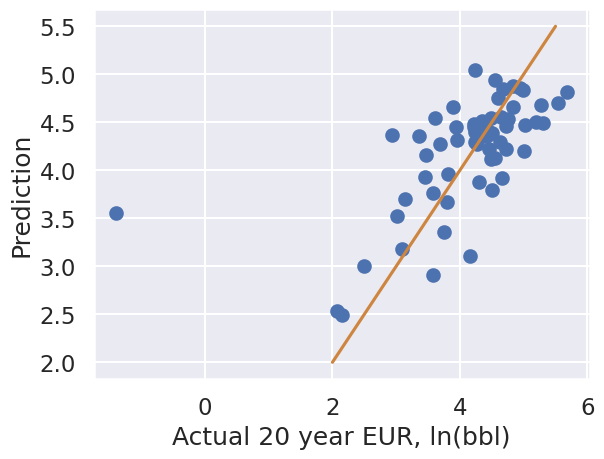

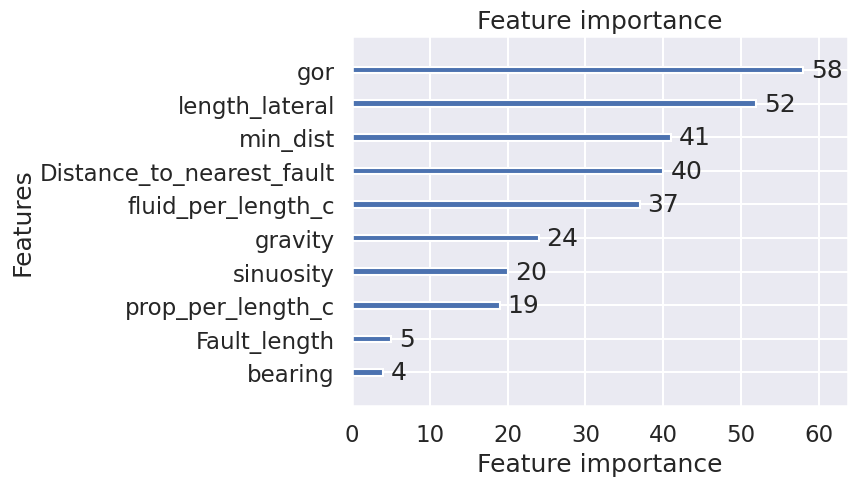

In [9]:
y_pred = reg.predict(X_test)
fig, ax = plt.subplots()
ax.scatter(y_test, y_pred)
ax.plot([2, 5.5], [2, 5.5], color="peru")
ax.set(xlabel="Actual 20 year EUR, ln(bbl)", ylabel="Prediction")
print(
    "MAE:",
    mean_absolute_error(y_test, y_pred),
    "\nMSE:",
    mean_squared_error(y_test, y_pred),
    "\nR2:",
    r2_score(y_test, y_pred),
)
lgb.plot_importance(reg)

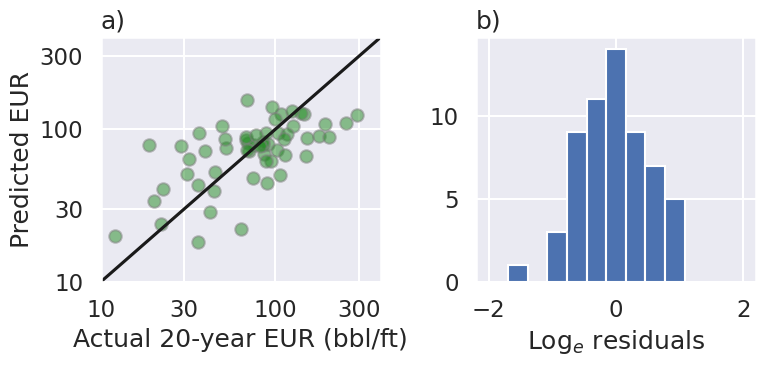

In [18]:
test_preds = reg.predict(X_test)
train_preds = reg.predict(X_train)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
lims = [10, 400]
ax1.plot(lims, lims, "k-")
ax1.scatter(
    np.exp(y_test),
    np.exp(test_preds),
    color="forestgreen",
    alpha=0.5,
    edgecolors="gray",
)

ax1.set(
    xlabel="Actual 20-year EUR (bbl/ft)",
    xlim=lims,
    xscale="log",
    ylabel="Predicted EUR",
    ylim=lims,
    yscale="log",
)
ax1.set_title("a)", loc="left")

tickmarks = [10, 30, 100, 300]
ax1.set_xticks(tickmarks)
ax1.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax1.set_yticks(tickmarks)
ax1.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax2.hist(y_test - test_preds, bins=np.linspace(-2, 2, 14))
ax2.set(xlabel="Log$_e$ residuals")
ax2.set_title("b)", loc="left")

fig.tight_layout()

# SHAP

In [19]:
reg.params["objective"] = "regression"
explainer = shap.TreeExplainer(reg)
shap_values = explainer.shap_values(X_test)

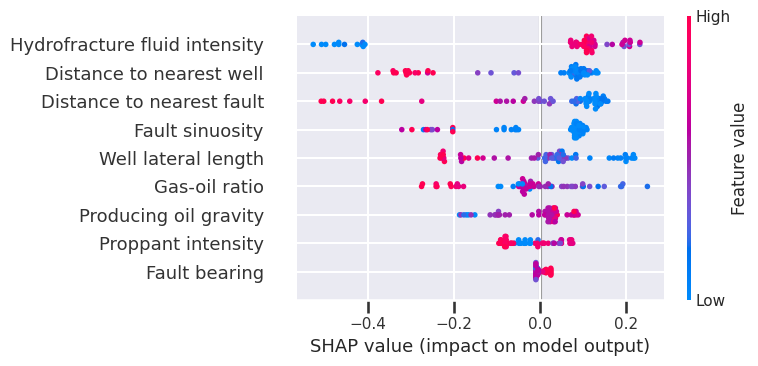

In [20]:
shap_values_df = pd.DataFrame(shap_values, columns=X_test.columns, index=X_test.index)
col_rename = {
    "fluid_per_length_c": "Hydrofracture fluid intensity",
    "Distance_to_nearest_fault": "Distance to nearest fault",
    "min_dist": "Distance to nearest well",
    "prop_per_length_c": "Proppant intensity",
    "gor": "Gas-oil ratio",
    "sinuosity": "Fault sinuosity",
    "length_lateral": "Well lateral length",
    "gravity": "Producing oil gravity",
    "bearing": "Fault bearing",
    "Fault_length": "Fault length",
    "stages_number": "Number of HF stages",
}
drop_cols = ["Fault_length", "stages_number"]

shap.summary_plot(
    shap_values_df.drop(columns=drop_cols).values,
    X_test.drop(columns=drop_cols).rename(columns=col_rename),
    show=False,
    plot_size=(8, 4),
)

[(1.0, 1.0611058)]

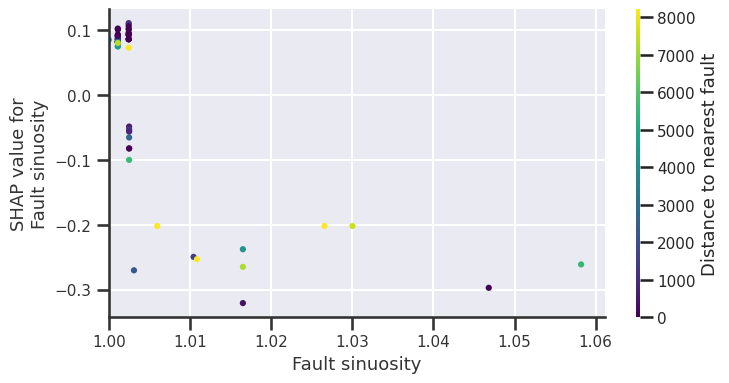

In [21]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.dependence_plot(
    "Fault sinuosity",
    shap_values,
    X_test.rename(columns=col_rename),
    show=False,
    cmap="viridis",
    dot_size=20,
    ax=ax,
)
ax.set(xlim=(1, None))


[(0.0, 5.0)]

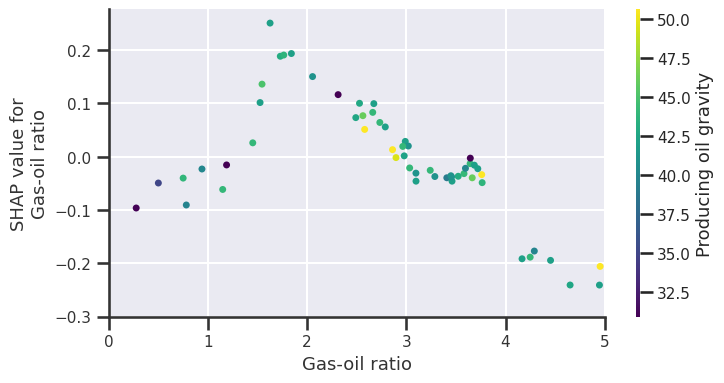

In [22]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.dependence_plot(
    "Gas-oil ratio",
    shap_values,
    X_test.rename(columns=col_rename),
    show=False,
    interaction_index="Producing oil gravity",
    cmap="viridis",
    dot_size=25,
    ax=ax,
)
ax.set(xlim=(0, 5))

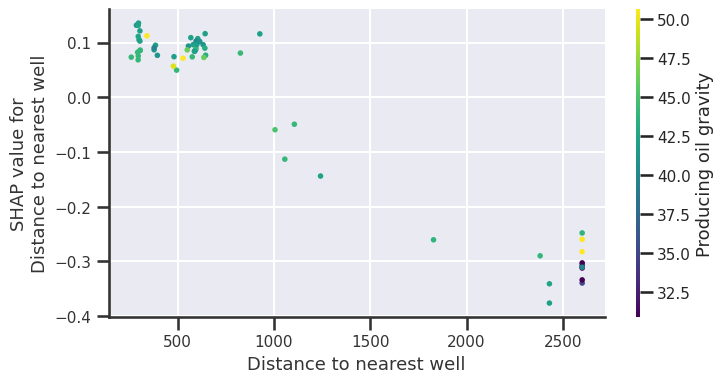

In [23]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.dependence_plot(
    "Distance to nearest well",
    shap_values,
    X_test.rename(columns=col_rename),
    show=False,
    cmap="viridis",
    ax=ax,
)

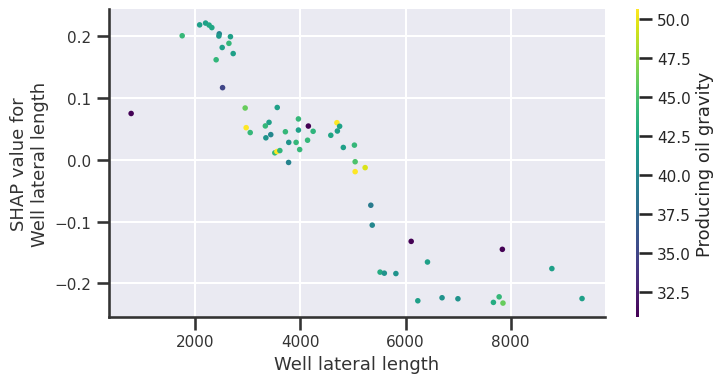

In [24]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.dependence_plot(
    "Well lateral length",
    shap_values,
    X_test.rename(columns=col_rename),
    show=False,
    cmap="viridis",
    ax=ax,
)

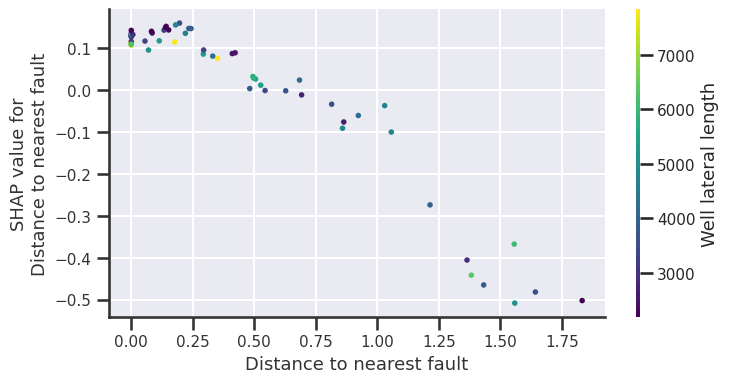

In [25]:
fig, ax = plt.subplots(figsize=(8, 4))
shap.dependence_plot(
    "Distance to nearest fault",
    shap_values,
    X_test.rename(columns=col_rename).assign(
        **{"Distance to nearest fault": lambda x: x["Distance to nearest fault"] / 5280}
    ),
    show=False,
    cmap="viridis",
    ax=ax,
)